In [53]:
import sys
sys.path.append("..")
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from src.spectra import sensor_spectra


#### compute setup

In [172]:
# ---- load data ----- #
df1 = pd.read_parquet('../data_interim/df1.parquet')
df6 = pd.read_parquet('../data_interim/df6.parquet')

## --------- compute setup ------------ ##
# time align the 2 sensors
aligned_n = pd.concat([df1['h'].rename('near'), df6['h'].rename('far')], axis=1).dropna()

# instead of a global mean, using a rolling 3 hour mean to track 
# the setup more locally 
tt = '3H'
shore_tt = aligned_n['near'] - aligned_n['near'].rolling(tt, center=True).mean()
far_tt = aligned_n['far'] - aligned_n['far'].rolling(tt, center=True).mean()

n = shore_tt - far_tt


/var/folders/7q/04p1sn755vg5x39skt2hykjh0000gn/T/ipykernel_52984/1317686791.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  shore_tt = aligned_n['near'] - aligned_n['near'].rolling(tt, center=True).mean()
/var/folders/7q/04p1sn755vg5x39skt2hykjh0000gn/T/ipykernel_52984/1317686791.py:13: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  far_tt = aligned_n['far'] - aligned_n['far'].rolling(tt, center=True).mean()


### complex demod
choosing Jan 13/14 swell

In [156]:
## ------Complex Demodulation Function-------- ##

import numpy as np
import pandas as pd
from scipy.signal import spectrogram, butter, filtfilt

def complex_demod(
    df,
    start,
    end,
    p_col="h",
    f_swell=(0.05, 0.2), 
    f_env_max=0.04,      # 0.04 Hz is standard for IG-cutoff
    fs=1.0,
):
    # 1. Subset
    df_win = df.loc[start:end].copy()
    if len(df_win) < 1024: return None

    x = df_win[p_col].to_numpy()

    # Detrend the raw signal before processing to remove tidal drift??
    x = x - np.polyval(np.polyfit(np.arange(len(x)), x, 1), np.arange(len(x)))
    
    t_ns = df_win.index.values.astype('datetime64[ns]').astype(np.int64)
    t_sec = (t_ns - t_ns[0]) / 1e9

    # 2. Find the local peak frequency
    # 17 minute spectral averaging
    f, t_spec, Sxx = spectrogram(x, fs=fs, nperseg=1024, noverlap=512)
    S_avg = Sxx.mean(axis=1)
    mask = (f >= f_swell[0]) & (f <= f_swell[1])
    f0 = f[mask][np.argmax(S_avg[mask])]

    # 3. Bandpass (Isolating the Sea/Swell band)
    nyq = 0.5 * fs
    b_bp, a_bp = butter(4, [f_swell[0]/nyq, f_swell[1]/nyq], btype="band")
    x_ss = filtfilt(b_bp, a_bp, x)

    # 4. Demodulate (Thomson & Emery Sec 5.5)
    z_raw = x_ss * np.exp(-1j * 2 * np.pi * f0 * t_sec)

    # 5. Low-pass (Isolating the Envelope)
    # Using your f_env_max (e.g., 0.004Hz for very smooth or 0.04Hz for IG)
    b_lp, a_lp = butter(4, f_env_max/nyq, btype="low")
    z = filtfilt(b_lp, a_lp, z_raw)    

    # 6. Physical Scaling
    A = 2 * np.abs(z)  # Amplitude
    E = A**2           # Energy (Proportional to Radiation Stress)

    return {
        "f0": f0,
        "period": 1/f0,
        "A": pd.Series(A, index=df_win.index),
        "E": pd.Series(E, index=df_win.index),
        "x_ss": x_ss,
        "t": df_win.index
    }


In [157]:
def complex_demod_hourly(
    df,
    start,
    end,
    p_col="h",
    f_swell=(0.05, 0.2),
    f_env_max=0.04,
    fs=1.0
):
    """
    Performs complex demodulation in 1-hour blocks to track 
    shifting carrier frequencies (f0) over time.
    """
    all_results = []
    
    # Create 1-hour bins
    hours = pd.date_range(start=start, end=end, freq='1H')
    
    for h_start in hours:
        h_end = h_start + pd.Timedelta(hours=1)
        
        # Use the logic from complex_demod function
        res = complex_demod(df, h_start, h_end, p_col, f_swell, f_env_max, fs)
        
        if res is not None:
            # Store the local results in a temporary DataFrame
            temp_df = pd.DataFrame({
                'A': res['A'],
                'E': res['E'],
                'x_ss': res['x_ss'],
                'f0_local': res['f0']
            }, index=res['t'])
            all_results.append(temp_df)
            
    if not all_results:
        return None
        
    # Combine everything back into one continuous DataFrame
    final_df = pd.concat(all_results)
    return final_df

/var/folders/7q/04p1sn755vg5x39skt2hykjh0000gn/T/ipykernel_52984/378728462.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hours = pd.date_range(start=start, end=end, freq='1H')


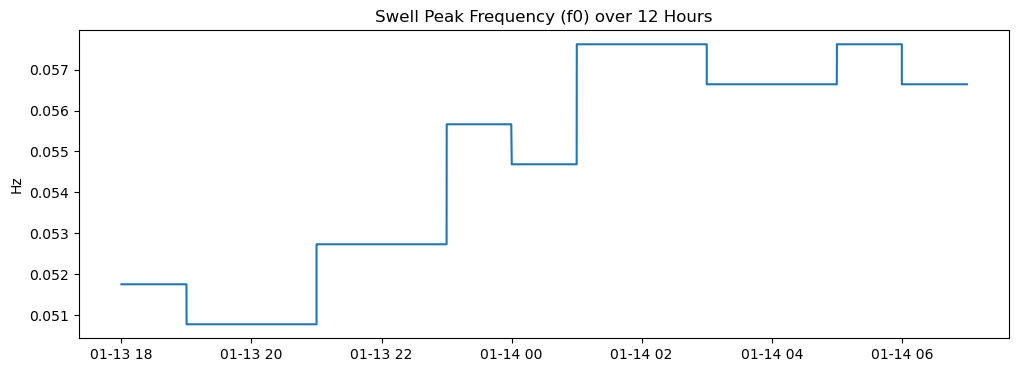

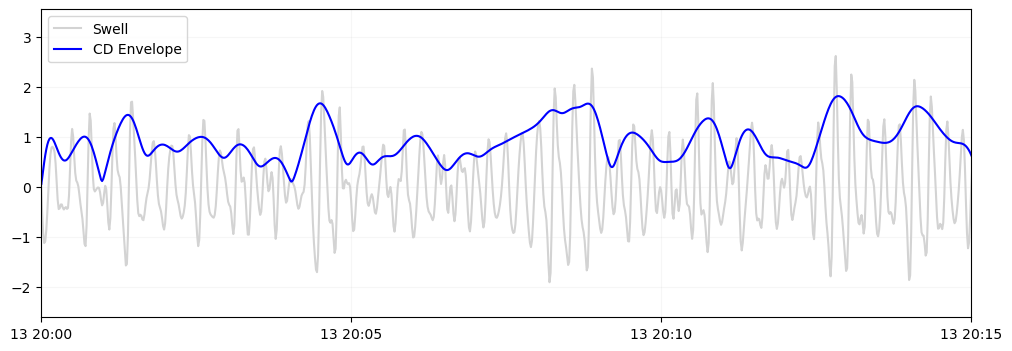

In [158]:
# Run the hourly demod
start = pd.Timestamp("2008-01-13 18:00:00")
end = pd.Timestamp("2008-01-14 06:00:00")
storm_results = complex_demod_hourly(df6, start, end)

# Plot the changing f0 to see the storm evolve
plt.figure(figsize=(12,4))
plt.plot(storm_results.index, storm_results['f0_local'])
plt.title("Swell Peak Frequency (f0) over 12 Hours")
plt.ylabel("Hz")
plt.show()

# Verification Plot (now using stitched hourly data)
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(storm_results.index, storm_results['x_ss'], color='lightgray', label='Swell')
ax.plot(storm_results.index, storm_results['A'], color='blue', label='CD Envelope')
plt.xlim(pd.Timestamp("2008-01-13 20:00:00"), pd.Timestamp("2008-01-13 20:15:00"))
plt.legend()
plt.grid(True, alpha=0.1)
plt.show()

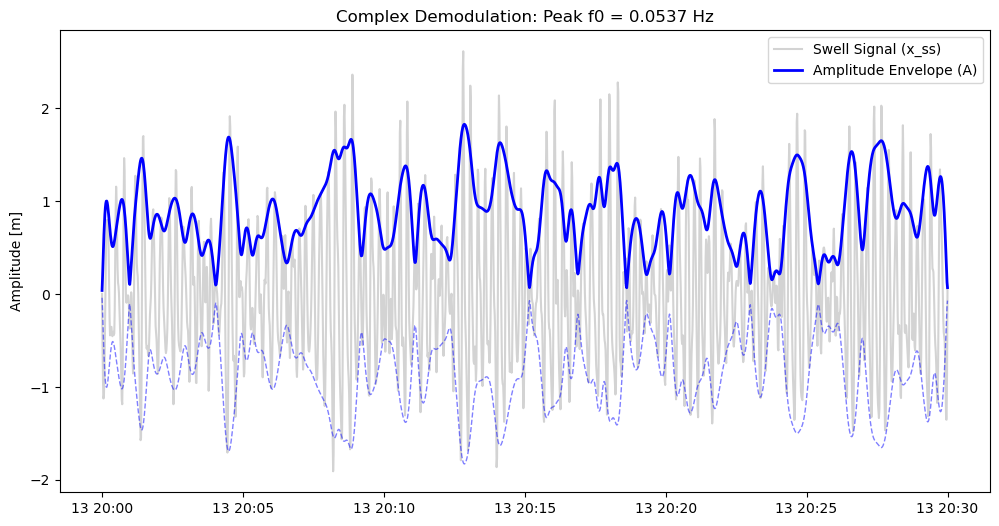

In [159]:
# 1. Run on your storm peak
res = complex_demod(df6, "2008-01-13 20:00:00", "2008-01-13 20:30:00")

# 2. Diagnostic Plot
plt.figure(figsize=(12, 6))
# Plot the band-passed sea/swell
plt.plot(res['t'], res['x_ss'], color='lightgray', label='Swell Signal (x_ss)')
# Plot the extracted envelope
plt.plot(res['t'], res['A'], color='blue', lw=2, label='Amplitude Envelope (A)')
plt.plot(res['t'], -res['A'], color='blue', lw=1, ls='--', alpha=0.5)

plt.title(f"Complex Demodulation: Peak f0 = {res['f0']:.4f} Hz")
plt.ylabel("Amplitude [m]")
plt.legend()
plt.show()

<>:18: SyntaxWarning: invalid escape sequence '\D'
<>:18: SyntaxWarning: invalid escape sequence '\D'
/var/folders/7q/04p1sn755vg5x39skt2hykjh0000gn/T/ipykernel_52984/1839664774.py:18: SyntaxWarning: invalid escape sequence '\D'
  ax[1].set_ylabel('Setup $\Delta \eta$ [m]')


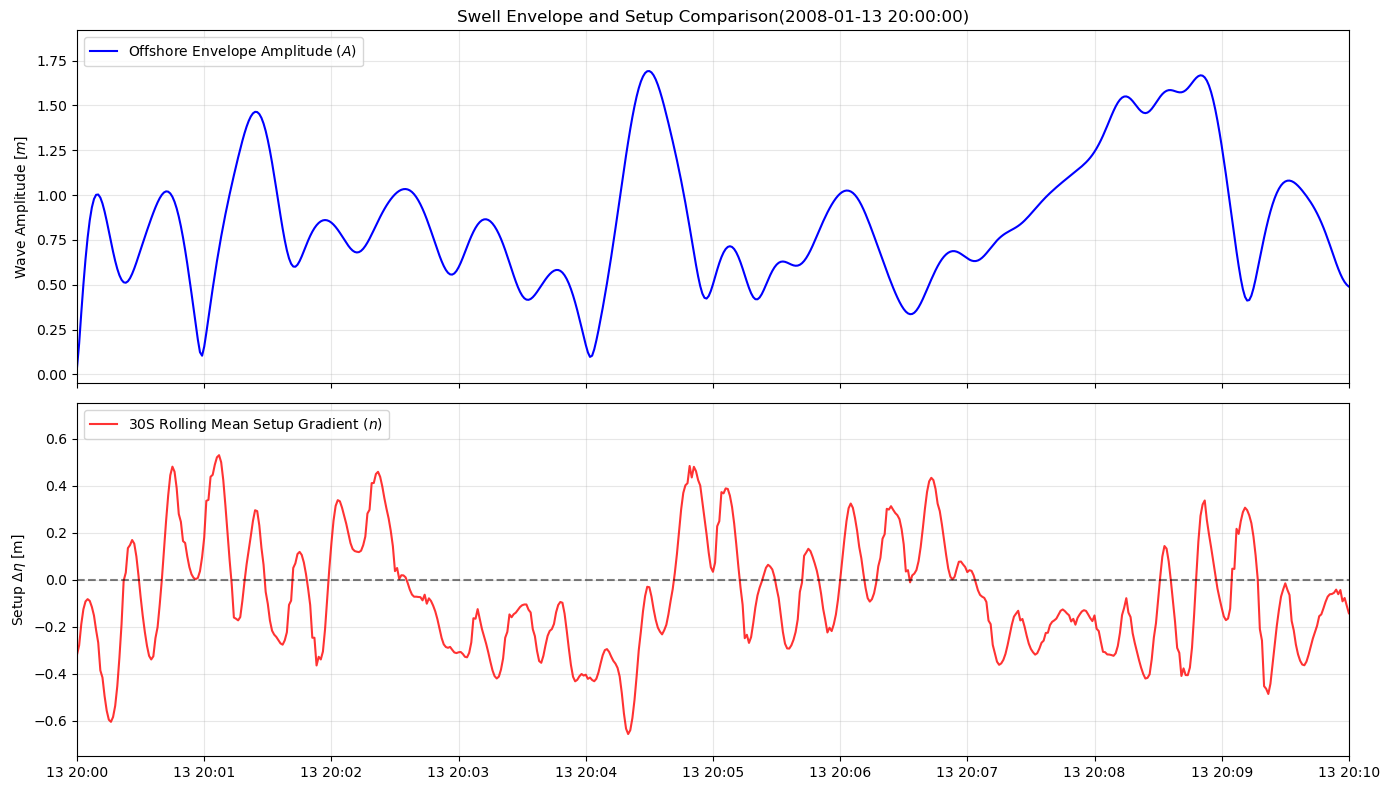

In [160]:

n_win = n.loc[start : end]

target_hour = "2008-01-13 20:00:00"

# 3. Plotting the Comparison
fig, ax = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Top Panel: The Wave Forcing (Offshore Groups)
ax[0].plot(res['t'], res['A'], color='blue', label='Offshore Envelope Amplitude ($A$)')
ax[0].set_ylabel('Wave Amplitude [$m$]')
ax[0].set_title(f'Swell Envelope and Setup Comparison({str(target_hour)})')
ax[0].legend(loc='upper left')
ax[0].grid(True, alpha=0.3)

# Bottom Panel: The Setup Response (Nearshore Gradient)
ax[1].plot(n_win.index, n_win.rolling('30s').mean(), color='red', alpha=0.8, label='30S Rolling Mean Setup Gradient ($n$)')
ax[1].axhline(0, color='black', linestyle='--', alpha=0.5)
ax[1].set_ylabel('Setup $\Delta \eta$ [m]')
ax[1].legend(loc='upper left')
ax[1].grid(True, alpha=0.3)
ax[1].set_ylim([-0.75,0.75])

# zoom in
plt.xlim(pd.Timestamp("2008-01-13 20:00:00"), pd.Timestamp("2008-01-13 20:10:00"))
plt.tight_layout()
plt.show()


In [161]:
n.rolling('30s').mean()

2007-12-14 12:00:01.000004608    0.252628
2007-12-14 12:00:01.999999232    0.291443
2007-12-14 12:00:03.000003840    0.297542
2007-12-14 12:00:03.999998208    0.297729
2007-12-14 12:00:05.000003072    0.290574
                                   ...   
2008-01-17 23:59:35.999999488    0.017579
2008-01-17 23:59:37.000004096    0.049595
2008-01-17 23:59:37.999998464    0.046599
2008-01-17 23:59:39.000003328    0.049029
2008-01-17 23:59:39.999997952    0.046821
Length: 2979420, dtype: float64

<>:25: SyntaxWarning: invalid escape sequence '\D'
<>:25: SyntaxWarning: invalid escape sequence '\D'
/var/folders/7q/04p1sn755vg5x39skt2hykjh0000gn/T/ipykernel_52984/260146613.py:25: SyntaxWarning: invalid escape sequence '\D'
  ax[1].set_ylabel('$\Delta \eta$ [m]')


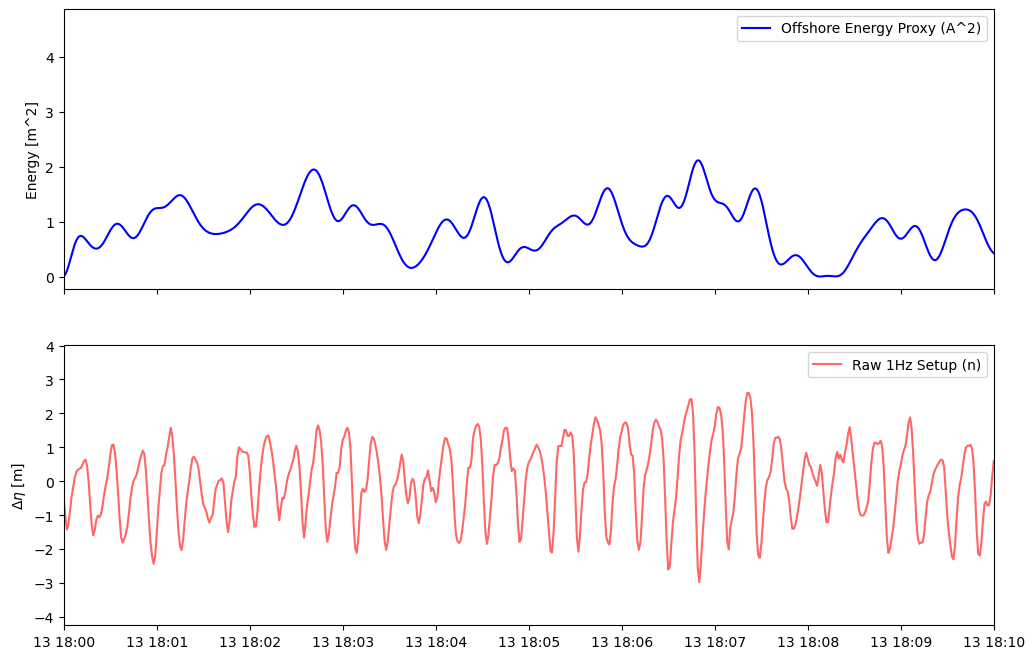

In [162]:
# inputs for complex demod
start = pd.Timestamp("2008-01-13 18:00:00")
end = pd.Timestamp("2008-01-14 06:00:00")
df = df6
fenv_max = 0.04
p_col='h'

res_far = complex_demod(
    df,
    start,
    end,
    p_col=p_col,
    f_env_max=fenv_max,      # Cutoff for the envelope (IG/Setup scale)
)

fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Forcing: The offshore wave energy
ax[0].plot(res_far['t'], res_far['E'], color='blue', label='Offshore Energy Proxy (A^2)')
ax[0].set_ylabel('Energy [m^2]')
ax[0].legend()

# Response: The cross-shore gradient
ax[1].plot(n.index, n ,color='red', alpha=0.6, label='Raw 1Hz Setup (n)')
ax[1].set_ylabel('$\Delta \eta$ [m]')
ax[1].legend()



plt.xlim(start, start + pd.Timedelta(minutes=10)) # Zoom in to see the 'noise'
plt.show()


### Extract IG signal from nearshore sensor

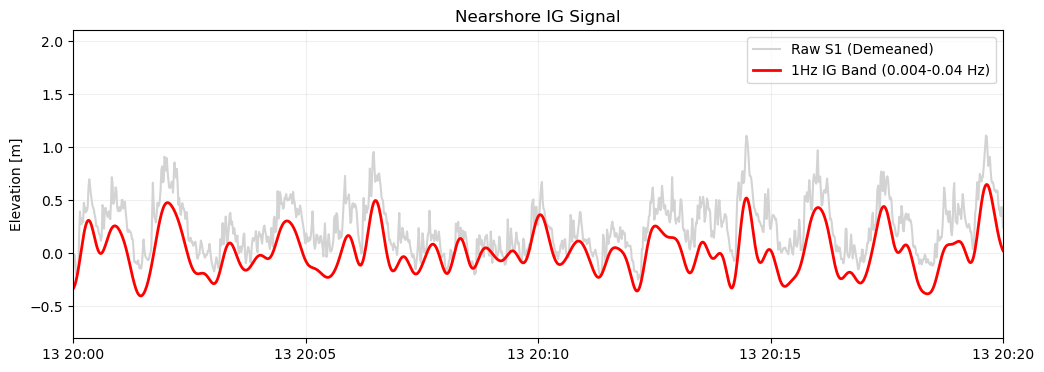

In [130]:
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt

def extract_ig(df, p_col='h', fs=1.0, f_low=0.004, f_high=0.04):
    """
    Extracts the 1Hz Infragravity (IG) time series using a Butterworth filter.
    
    Parameters:
    df     : DataFrame with DatetimeIndex
    p_col  : Column name for water level/depth (e.g., 'h')
    fs     : Sampling frequency (1.0 for 1Hz)
    f_low  : Lower IG cutoff (standard 0.004 Hz)
    f_high : Upper IG cutoff (standard 0.04 Hz)
    """
    # 1. Handle NaNs: filtfilt requires continuous data
    # We interpolate small gaps to keep the timing perfectly aligned
    series = df[p_col]
    x = series.to_numpy()
    
    # design the Butterworth Bandpass Filter
    nyq = 0.5 * fs
    low = f_low / nyq
    high = f_high / nyq
    
    # 4th order is usually sufficient for oceanographic signals
    b, a = butter(4, [low, high], btype='band')
    
    # apply the filter using filtfilt (Zero-phase filtering)
   
    ig_signal = filtfilt(b, a, x)
    
    return pd.Series(ig_signal, index=df.index, name='h_ig')

# --- S1 sensor ---
s1_ig = extract_ig(df1)

# --- sanity plot ---
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(df1.index, df1['h'] - df1['h'].mean(), color='lightgray', label='Raw S1 (Demeaned)')
plt.plot(s1_ig.index, s1_ig, color='red', lw=2, label='1Hz IG Band (0.004-0.04 Hz)')
plt.title("Nearshore IG Signal")
plt.ylabel("Elevation [m]")
plt.legend()
plt.grid(True, alpha=0.2)

# Zoom in to a 20-minute window to see the 'wiggles'
plt.xlim(pd.Timestamp("2008-01-13 20:00:00"), pd.Timestamp("2008-01-13 20:20:00"))
plt.show()

In [92]:
s1_ig

2007-12-14 12:00:01.000004608   -0.021750
2007-12-14 12:00:01.999999232   -0.024504
2007-12-14 12:00:03.000003840   -0.026968
2007-12-14 12:00:03.999998208   -0.028832
2007-12-14 12:00:05.000003072   -0.029825
                                   ...   
2008-03-15 11:59:35.999999488    0.011920
2008-03-15 11:59:37.000004096    0.010164
2008-03-15 11:59:37.999998464    0.007985
2008-03-15 11:59:39.000003328    0.005504
2008-03-15 11:59:39.999997952    0.002857
Name: h_ig, Length: 7945120, dtype: float64

### compare  Offshore swell envelope to nearshore IG

<>:25: SyntaxWarning: invalid escape sequence '\e'
<>:25: SyntaxWarning: invalid escape sequence '\e'
/var/folders/7q/04p1sn755vg5x39skt2hykjh0000gn/T/ipykernel_52984/1804706149.py:25: SyntaxWarning: invalid escape sequence '\e'
  ax[1].set_ylabel('$\eta_{IG}$ [m]')


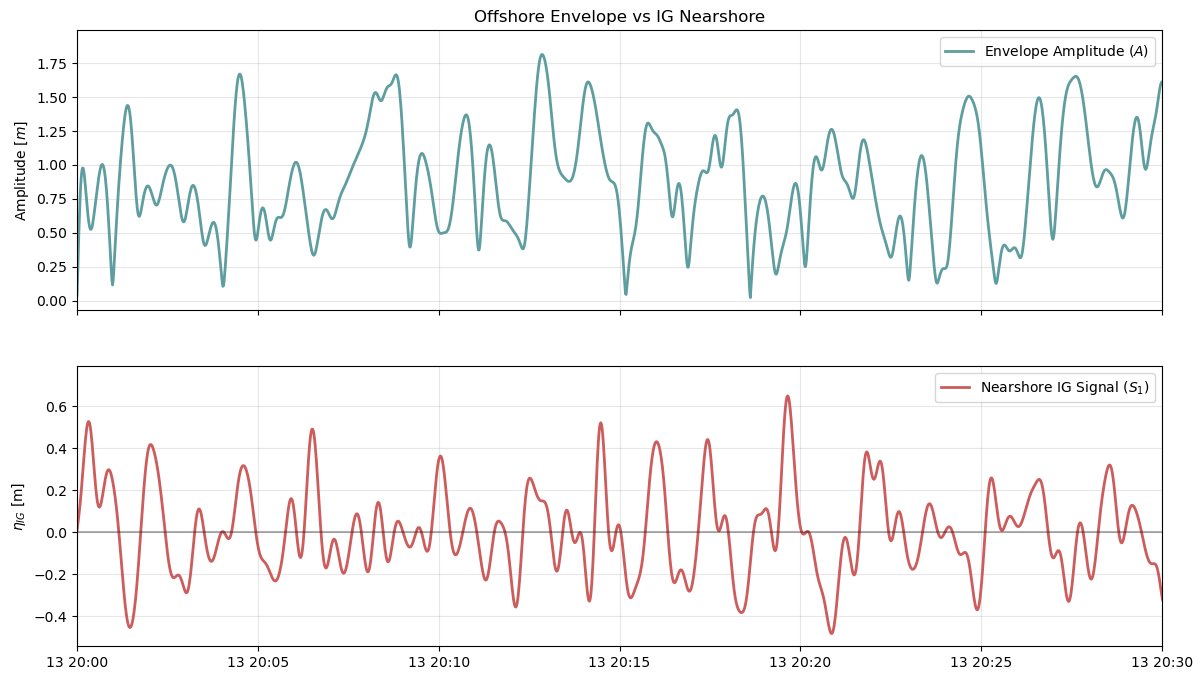

In [104]:
# 1. Define your peak storm window
start_peak = pd.Timestamp("2008-01-13 20:00:00")
end_peak = start_peak + pd.Timedelta(hours=1)

# 2. Extract the Offshore Forcing (S6)
res = complex_demod(df6, start_peak, end_peak)

# 3. Extract the Nearshore IG Response (S1)
# s1_ig is the 1Hz filtered signal (0.004 - 0.04 Hz)
s1_ig_win = extract_ig(df1.loc[start_peak:end_peak])

# 4. Plotting
fig, ax = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# offshore wave envelope
ax[0].plot(res['t'], res['A'], color='CadetBlue', linewidth=2, label='Envelope Amplitude ($A$)')
ax[0].set_ylabel('Amplitude [$m$]')
ax[0].set_title('Offshore Envelope vs IG Nearshore')
ax[0].legend()
ax[0].grid(True, alpha=0.3)

# Panel 2: Nearshore IG Oscillations
ax[1].plot(s1_ig_win.index, s1_ig_win, color='IndianRed', linewidth=2, label='Nearshore IG Signal ($S_1$)')
ax[1].axhline(0, color='black', alpha=0.3)
ax[1].set_ylabel('$\eta_{IG}$ [m]')
ax[1].legend()
ax[1].grid(True, alpha=0.3)


# Zoom to see 15 minutes of "Coincidence"
plt.xlim(start_peak , start_peak + pd.Timedelta(minutes=30))
plt.show()

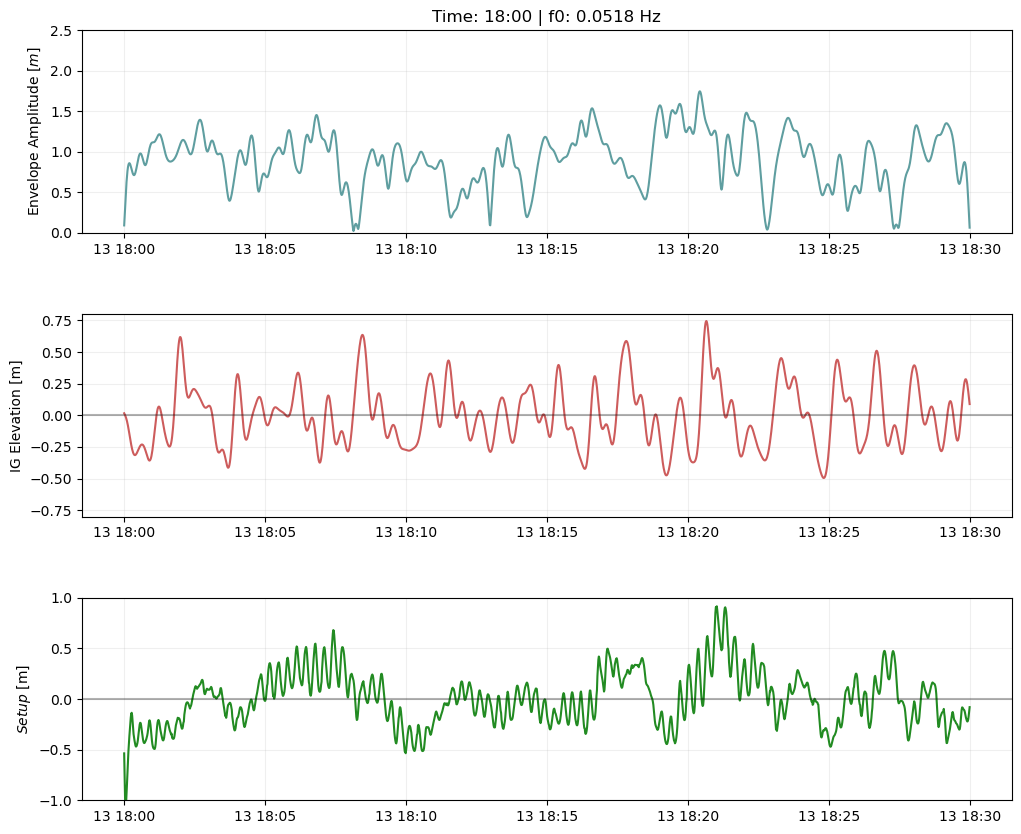

In [150]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML  # For Jupyter/VS Code display
import pandas as pd

#  setup Time Range
total_start = pd.Timestamp("2008-01-13 18:00:00")
total_end = pd.Timestamp("2008-01-14 06:00:00")
step = pd.Timedelta(minutes=30)
frames_list = pd.date_range(start=total_start, end=total_end - step, freq='30min')

# initialize figure
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10), sharex=False) 
plt.subplots_adjust(hspace=0.4)

def update(t_start):
    t_end = t_start + step
    
    # Clear axes
    ax1.clear()
    ax2.clear()
    ax3.clear()
    
    # Data extraction
    res_far = complex_demod(df6, t_start, t_end)
    s1_ig_chunk = extract_ig(df1.loc[t_start:t_end])
    n_chunk = n.loc[t_start:t_end]
    
    if res_far is not None and not n_chunk.empty:
        # Panel 1: Offshore Envelope
        ax1.plot(res_far['t'], res_far['A'], color='CadetBlue')
        ax1.set_ylim(0, 2.5) 
        ax1.set_title(f"Time: {t_start.strftime('%H:%M')} | f0: {res_far['f0']:.4f} Hz")
        ax1.set_ylabel(r"Envelope Amplitude [$m$]")

        # Panel 2: Nearshore IG 
        ax2.plot(s1_ig_chunk.index, s1_ig_chunk, color='IndianRed')
        ax2.axhline(0, color='black', alpha=0.3)
        ax2.set_ylim(-0.8, 0.8) 
        ax2.set_ylabel(r"IG Elevation [m]")

        # Panel 3: cross shore water level gradient
        ax3.plot(n_chunk.index, n_chunk.rolling('50s').mean(), color='forestgreen')
        ax3.axhline(0, color='black', alpha=0.3)
        ax3.set_ylim(-1, 1)
        ax3.set_ylabel(r"$Setup$ [m]")
        
        # Format X-axis for all
        for ax in [ax1, ax2, ax3]:
            ax.grid(True, alpha=0.2)

# Create the animation object
ani = FuncAnimation(fig, update, frames=frames_list, interval=800)
ani.save('Mokuleia_Swell_Evolution.gif', writer='pillow', fps=2) # save as mp4

# IF USING VS CODE, RUN THIS LINE INSTEAD OF PLT.SHOW():
HTML(ani.to_jshtml())


In [ ]:
import numpy as np
import pandas as pd
from scipy.signal import correlate

def analyze_lags(df_env, df_setup, fs=1.0, max_lag_sec=60):
    """
    Finds the lag that maximizes correlation between envelope and setup.
    """
    # Pre-process: Demean and Normalize (Standardize)
    # This ensures the correlation is scaled between -1 and 1
    env = (df_env - df_env.mean()) / df_env.std()
    setup = (df_setup - df_setup.mean()) / df_setup.std()
    
    # 2. Compute Cross-Correlation
    # 'full' mode gives us all possible lags
    corr = correlate(setup, env, mode='full')
    lags = np.arange(-len(env) + 1, len(env)) / fs
    
    # 3. Restrict to physically plausible lags 
    mask = (lags >= 0) & (lags <= max_lag_sec)
    phys_lags = lags[mask]
    phys_corr = corr[mask]
    
    # 4. Find the Peak
    # We use argmax(np.abs) because the correlation could be negative (Bound Wave)
    best_idx = np.argmax(np.abs(phys_corr))
    max_corr_val = phys_corr[best_idx] / len(env) # Normalized
    best_lag = phys_lags[best_idx]
    
    return best_lag, max_corr_val

results = []
print(f"Starting analysis for {len(frames_list)} frames...")

for t_start in frames_list:
    t_end = t_start + pd.Timedelta(minutes=15)
    
    # 1. Check Offshore Data
    res_dict = complex_demod(df6, t_start, t_end)
    if res_dict is None:
        # print(f"Skipping {t_start}: complex_demod returned None")
        continue
    
    env_chunk = res_dict['A']
    
    # 2. Check Nearshore Setup Data
    try:
        # Using .rolling().mean() can create NaNs at start/end, so we drop them
        setup_chunk = n.loc[t_start:t_end].rolling('30s').mean().dropna()
    except Exception as e:
        # print(f"Skipping {t_start}: Error slicing 'n' -> {e}")
        continue

    if setup_chunk.empty:
        # print(f"Skipping {t_start}: setup_chunk is empty")
        continue

    # 3. Align and Check Overlap
    common_idx = env_chunk.index.intersection(setup_chunk.index)
    
    if len(common_idx) > 120:
        lag, corr_val = analyze_lags(env_chunk[common_idx], setup_chunk[common_idx])
        results.append({
            'time': t_start, 
            'lag': lag, 
            'correlation': corr_val,
            'f0': res_dict['f0'] 
        })
    else:
        # print(f"Skipping {t_start}: Only {len(common_idx)} overlapping points found")
        pass

# 4. Final DataFrame Creation with Safety Check
if len(results) > 0:
    lag_df = pd.DataFrame(results).set_index('time')
    print(f"Successfully processed {len(lag_df)} frames.")
else:
    print("CRITICAL: No frames were processed. Please check if 'n' and 'df6' overlap in time.")
    lag_df = pd.DataFrame() # Create empty DF to prevent downstream errors

Starting analysis for 24 frames...
CRITICAL: No frames were processed. Please check if 'n' and 'df6' overlap in time.


In [1]:
100/8

12.5